# Splitpea - Sample-specific Mode (rMATS)

**Goal**: Use Splitpea to generate a sample specific network for a metastatic prostate cancer cell line against normal uterus tissue samples. In this example we show how to use an rMATS output directly against our pre-bundled normal tissue data from IRIS DB.

In [ ]:
#@title 0. Install and import dependencies

%%capture

!pip install --index-url https://test.pypi.org/simple/ \
            --extra-index-url https://pypi.org/simple splitpea

!sudo apt-get install tabix  # Tabix is used under-the-hood for some of the functions

import splitpea

In [ ]:
!splitpea --help  # Splitpea can be run both as a command-line tool and as a Python library

usage: splitpea [-h]
                {run,plot,stats,calculate_delta_psi,combine_spliced_exon,preprocess_pooled,get_consensus_network}
                ...

splitpea: SPLicing InTeractions PErsonAlized

positional arguments:
  {run,plot,stats,calculate_delta_psi,combine_spliced_exon,preprocess_pooled,get_consensus_network}
    run                 calculate and output rewired network
    plot                load a saved rewired network (.edges.pickle) and
                        produce plots
    stats               compute and write gene level statistics for a rewired
                        splicing PPI network
    calculate_delta_psi
                        Calculate delta PSI values and p-values for background
                        vs compare exon comparisons
    combine_spliced_exon
                        Combine individual spliced-exon PSI files into a
                        single mean PSI file per exon
    preprocess_pooled   Download or use existing background psi files, com

## 1. Run the built-in preprocessing function

For this example, we use data downloaded from [Zenodo](https://zenodo.org/records/6647024). The dataset comes from the manuscript “rMATS-turbo: an efficient and flexible computational tool for alternative splicing analysis of large-scale RNA-seq data” by Wang et. al.

rMATS produces two alternative splicing event files for skipped exons (SE):  
- `SE.MATS.JCEC.txt` — counts both junction reads and reads spanning the exon body  
- `SE.MATS.JC.txt` — counts only junction reads  

Either file can be directly used as input to Splitpea as is. In this analysis, we specifically use `SE.MATS.JCEC.txt` as our input file from the **PC3E** and **GS689** cell line comparision (PC3E-GS689.tar.gz). We will run the analysis on the GS689 sample only in this example. ***Please upload this file to the notebook environment before running the following analysises.***

This function builds the inputs (`{sample}-psi.txt`) for Splitpea’s sample-specific mode in `out_psi_dir` (e.g., `"/content/GS689_PSI"`). It first averages exon-level splicing across normal pancreas samples to create a background, then computes ΔPSI and empirical p-values on the rMATS GS689 case (`compare_path`). The preprocessing step accepts rMATS outputs either as a single file or as a folder. When given a folder, it aggregates all files (renamed to the desired sample names) into one matrix that can be passed to `preprocess_pooled` to generate multiple Splitpea input files at once.   In the example shown here we use a single rMATS file by setting `single_rMATS_compare=True`, and because this differential rMATS file contains two samples and we want to anaylze the second sample, we select that sample with `inclevel=2`. (Note: if rMATS was run per-sample, use `inclevel=1`.)


In [ ]:
splitpea.preprocess_pooled(
    compare_path="/content/SE.MATS.JCEC.txt",
    background="pancreas",
    background_download_root="/content/IRIS_pancreas/",
    out_psi_dir="/content/GS689_PSI",
    single_rMATS_compare= True,
    inclevel = 2

)

Y. Pan, J.W. Phillips, B.D. Zhang, M. Noguchi, E. Kutschera, J. McLaughlin, P.A. Nesterenko, Z. Mao, N.J. Bangayan, R. Wang, W. Tran, H.T. Yang, Y. Wang, Y. Xu, M.B. Obusan, D. Cheng, A.H. Lee, K.E. Kadash-Edmondson, A. Champhekar, C. Puig-Saus, A. Ribas, R.M. Prins, C.S. Seet, G.M. Crooks, O.N. Witte, & Y. Xing, IRIS: Discovery of cancer immunotherapy targets arising from pre-mRNA alternative splicing, Proc. Natl. Acad. Sci. U.S.A. 120 (21) e2221116120, https://doi.org/10.1073/pnas.2221116120 (2023).
processing file: splicing_matrix.SE.cov10.GTEx_Pancreas.txt
Starting delta PSI calculation...
Processing sample SE.MATS.JCEC...


'/content/GS689_PSI'

## 2. Run Splitpea

To run Splitpea, call the `splitpea.run` function with two key arguments:  
1. the output file from `splitpea.preprocess_pooled`
2. an output prefix.  

You can also customize the run by adjusting additional parameters, such as modifying PSI and p-value filters for events to be considered or providing your own alternative reference files in place of the defaults. For a full list of options, see the package's [documentation](https://github.com/ylaboratory/splitpea_package).

This will generate two files:  
- `<out_file_prefix>.edges.dat`: a per-edge summary table  
- `<out_file_prefix>.edges.pickle`: a pickled NetworkX graph of the rewired network

In [ ]:
splitpea.run("/content/GS689_PSI/SE.MATS.JCEC-psi.txt", "GS689_pancreas", verbose = True)

INFO:diff_exon:Loading DDIs....
INFO:diff_exon:# pfams: 8602, # ddis: 17450
INFO:diff_exon:Loading PPIs....
INFO:diff_exon:# proteins: 20286, # interactions: 793078
INFO:diff_exon:Loading gene-protein domain info....
INFO:diff_exon:Reading differential exon results....
INFO:diff_exon:Reading in input exons...
INFO:diff_exon:# of differentially expressed exons: 905
INFO:diff_exon:Calculating network....
INFO:diff_exon:# nodes: 913, # edges: 1012
INFO:diff_exon:Outputting as pickle...
INFO:diff_exon:Done


## 3. Visualizing the rewired network  

You can either visualize the network directly in Python with the `splitpea.plot` function, or export it for use in dedicated tools such as Gephi or Cytoscape.  

To do this, you can simply pass in the `.edges.pickle` file generated by `splitpea.run` as input to `splitpea.plot`. In the example below, we export the network to all three formats. To make the visualization clearer, we set `self_edges=False` (removes self-loops) and `lcc=True` (keeps only the largest connected component). These parameters are optional and can be adjusted depending on your analysis needs.  

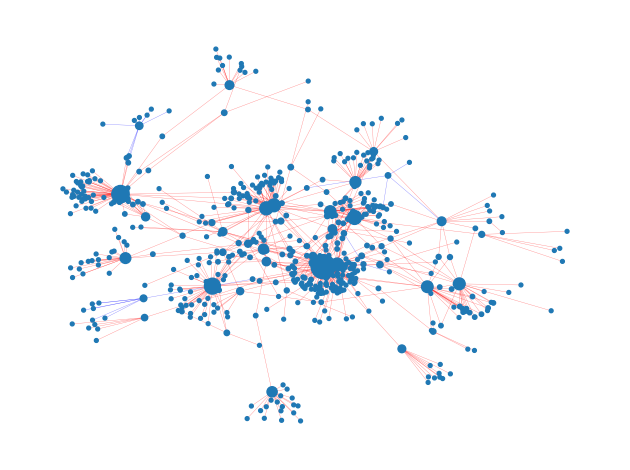

Generated outputs:
  PDF → GS689_pancreas.pdf
  Gephi TSV → GS689_pancreas.tsv
  Cytoscape GML → GS689_pancreas.gml


In [ ]:
splitpea.plot("/content/GS689_pancreas.edges.pickle", pdf_path ="GS689_pancreas.pdf",  gephi_path ="GS689_pancreas.tsv", cytoscape_path = "GS689_pancreas.gml", self_edges = False, lcc = True)

## 3. Questions? Feedback?

Please submit an issue through our [Github](https://github.com/ylaboratory/splitpea_package/issues) page.

#### PyPi repository

Want to try out Splitpea? Please download it from our PyPi repository: ...

#### Citations

...